Using data from the acclaimed US NEWS HEALTH website to uncover some interesting insights on healthcare recommendations.
According to the data, there are 720 cancer-specific hospitals across the nation. With 68 of these hospitals, California leads the way, followed by Texas with 48 and Florida with 48 each. Among the top five are 45 cancer-specialty hospitals in New York, along with 43 in Pennsylvania.

Let's talk quality now. Our analysis of the data revealed that New York, California, and Texas had the top 3 hospitals ranked in the 80th percentile for cancer specialties, with impressive counts of 17, 15, and 13, respectively. In terms of cancer care, these are some of the best.

As for the bottom 10 percent, the top three states with the highest counts were California, Pennsylvania, and Alabama, with a combined count of six.

Not only does this data provide a detailed picture of the distribution of cancer-specialized hospitals, it also reveals the concentration of top-performing institutions in certain states. In our ongoing research, we look forward to exploring more nuances in the healthcare landscape.



In [213]:
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

import numpy as np
from geopy.geocoders import Nominatim
import pgeocode

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import sys 
sys.path.insert(0, '../config/')
from wallet import mapbox_token

In [8]:
cancer_df = pd.read_csv('../data/us_cancer_center_720.csv').iloc[:,1:]
cancer_df.rename(columns = {'Name (Specialty)':'NAME',
                            'AHA ID':'AHA_ID',
                            'Specialty Score':'SCORE',
                            'Specialty Ranking':'RANKING'}, inplace = True)
print(cancer_df.shape)
cancer_df.head()

(720, 8)


,NAME,AHA_ID,ZIP,STATE,SCORE,RANKING,LATITUDE,LONGITUDE
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0/100,1.0,29.707670,-95.397844
1,Mayo Clinic,6610451,53821,WI,79.9/100,3.0,43.051688,-91.132867
2,UCLA Medical Center,6931755,90095,CA,73.2/100,5.0,34.065563,-118.445498
3,Cleveland Clinic,6410670,44333,OH,71.9/100,6.0,41.131162,-81.610786
4,Cedars-Sinai Medical Center,6930444,90048,CA,67.7/100,11.0,34.075160,-118.381094


# Find any missing value

In [9]:
cancer_df.isna().sum()

NAME           0
AHA_ID         0
ZIP            0
STATE          0
SCORE          0
RANKING      692
LATITUDE       0
LONGITUDE      0
dtype: int64

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '16'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '22'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '43'),
 Text(0, 0, '45'),
 Text(0, 0, '48'),
 Text(0, 0, '48'),
 Text(0, 0, '68')]

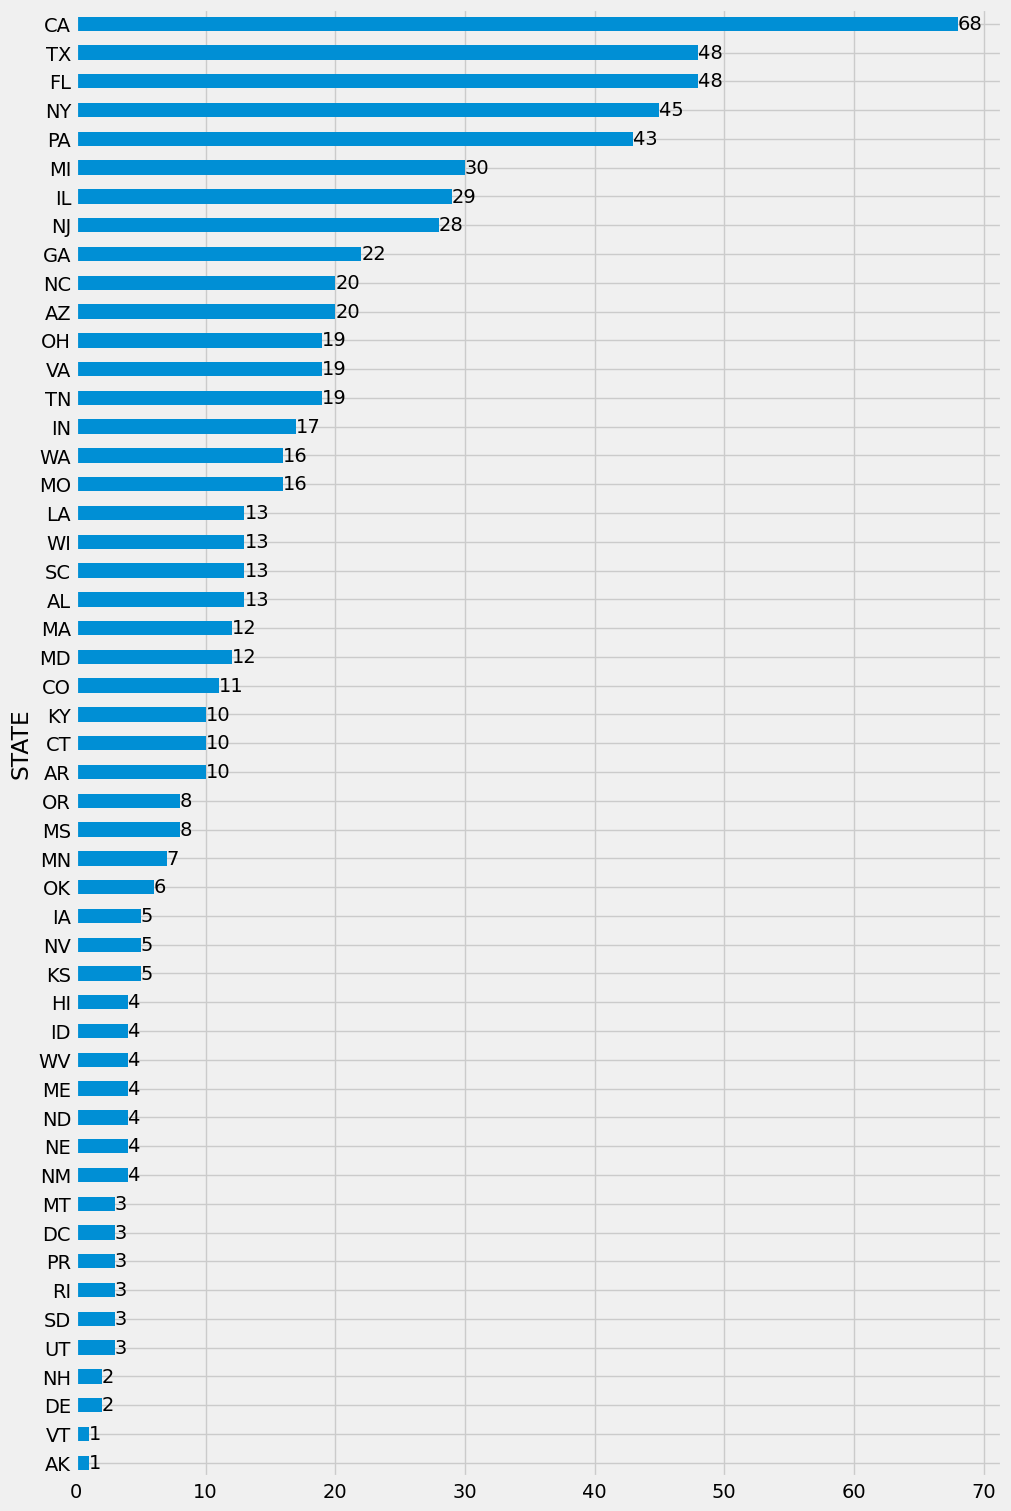

In [15]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df.groupby(['STATE'])['NAME'].size().sort_values().plot.barh()
ax.bar_label(ax.containers[0])

In [32]:
cancer_df['RAW_SCORE'] = cancer_df.SCORE.apply(lambda x: x.split('/')[0])
cancer_df['RAW_SCORE'] = cancer_df['RAW_SCORE'].astype('float64')

In [33]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       720 non-null    object 
 1   AHA_ID     720 non-null    object 
 2   ZIP        720 non-null    object 
 3   STATE      720 non-null    object 
 4   SCORE      720 non-null    object 
 5   RANKING    28 non-null     float64
 6   LATITUDE   720 non-null    float64
 7   LONGITUDE  720 non-null    float64
 8   RAW_SCORE  720 non-null    float64
dtypes: float64(4), object(5)
memory usage: 50.8+ KB


In [36]:
cancer_df.sort_values(by = 'RAW_SCORE', ascending = False)

,NAME,AHA_ID,ZIP,STATE,SCORE,RANKING,LATITUDE,LONGITUDE,RAW_SCORE
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0/100,1.0,29.707670,-95.397844,100.0
671,Memorial Sloan Kettering Cancer Center,6213060,10065-6007,NY,85.7/100,2.0,40.764100,-73.956000,85.7
1,Mayo Clinic,6610451,53821,WI,79.9/100,3.0,43.051688,-91.132867,79.9
2,UCLA Medical Center,6931755,90095,CA,73.2/100,5.0,34.065563,-118.445498,73.2
3,Cleveland Clinic,6410670,44333,OH,71.9/100,6.0,41.131162,-81.610786,71.9
...,...,...,...,...,...,...,...,...,...
662,Mercy Health-West Hospital,6410518,45211,OH,8.3/100,NaN,39.180947,-84.597303,8.3
663,Eastern Idaho Regional Medical Center,6820165,83404,ID,6.5/100,NaN,43.470267,-111.992095,6.5
664,Self Regional Healthcare-Greenwood,6370375,29646,SC,5.5/100,NaN,34.171872,-82.156478,5.5
665,McLaren Greater Lansing Hospital,6440009,48910,MI,4.6/100,NaN,42.701649,-84.501638,4.6


In [37]:
cancer_df['Percentile Rank'] = cancer_df.RAW_SCORE.rank(pct = True) 

In [72]:
cancer_df[cancer_df['Percentile Rank'] >= 0.80]['STATE'].value_counts().sort_values(ascending = True).tail()

PA    10
IL    12
TX    13
CA    15
NY    17
Name: STATE, dtype: int64

# Top 20% high score from NY

[Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '15'),
 Text(0, 0, '17')]

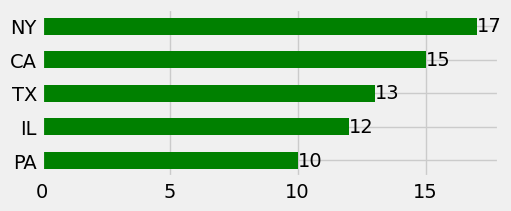

In [77]:
plt.figure(figsize=(5, 2),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df[cancer_df['Percentile Rank'] >= 0.80]['STATE'].value_counts().sort_values(ascending = True).tail().plot.barh(color = 'green')
ax.bar_label(ax.containers[0])


In [84]:
cancer_df[cancer_df['Percentile Rank'] >= 0.80].value_counts()

NAME                                                 AHA_ID   ZIP         STATE  SCORE      RANKING  LATITUDE   LONGITUDE    RAW_SCORE  Percentile Rank
AdventHealth Orlando                                 6390690  32803       FL     57.9/100   30.0     28.574632  -81.369372   57.9       0.977778           1
Beth Israel Deaconess Medical Center                 6140013  02215       MA     57.7/100   31.0     42.339790  -71.104881   57.7       0.975694           1
University of Texas MD Anderson Cancer Center        6741945  77030       TX     100.0/100  1.0      29.707670  -95.397844   100.0      1.000000           1
University of Kansas Hospital                        6670510  66160       KS     54.5/100   46.0     39.057110  -94.609544   54.5       0.965972           1
UT Southwestern Medical Center                       6740343  75390       TX     60.2/100   25.0     32.813843  -96.843914   60.2       0.981944           1
UCLA Medical Center                                  6931755  9

/var/folders/sv/sf850pgs5cvc4zsv0yyq1hhr0000gn/T/ipykernel_56940/4252618121.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'STATE', data = cancer_df[cancer_df['Percentile Rank'] >= 0.80],


Text(0.5, 1.0, 'Top Review Hospitals By State')

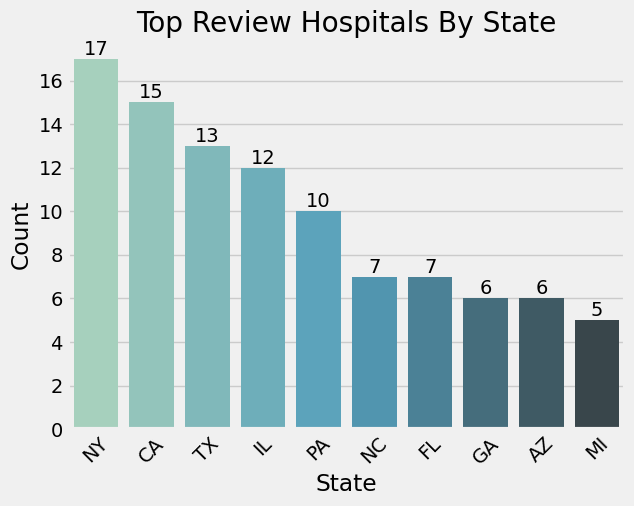

In [88]:
# plt.figure(figsize = (10, 5))

ax = sns.countplot(x = 'STATE', data = cancer_df[cancer_df['Percentile Rank'] >= 0.80],
              order = cancer_df[cancer_df['Percentile Rank'] >= 0.80]['STATE'].value_counts().head(10).index, palette='GnBu_d')
for label in ax.containers:
    ax.bar_label(label)
xt = plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Top Review Hospitals By State')

# Bottom 10

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '6'),
 Text(0, 0, '9')]

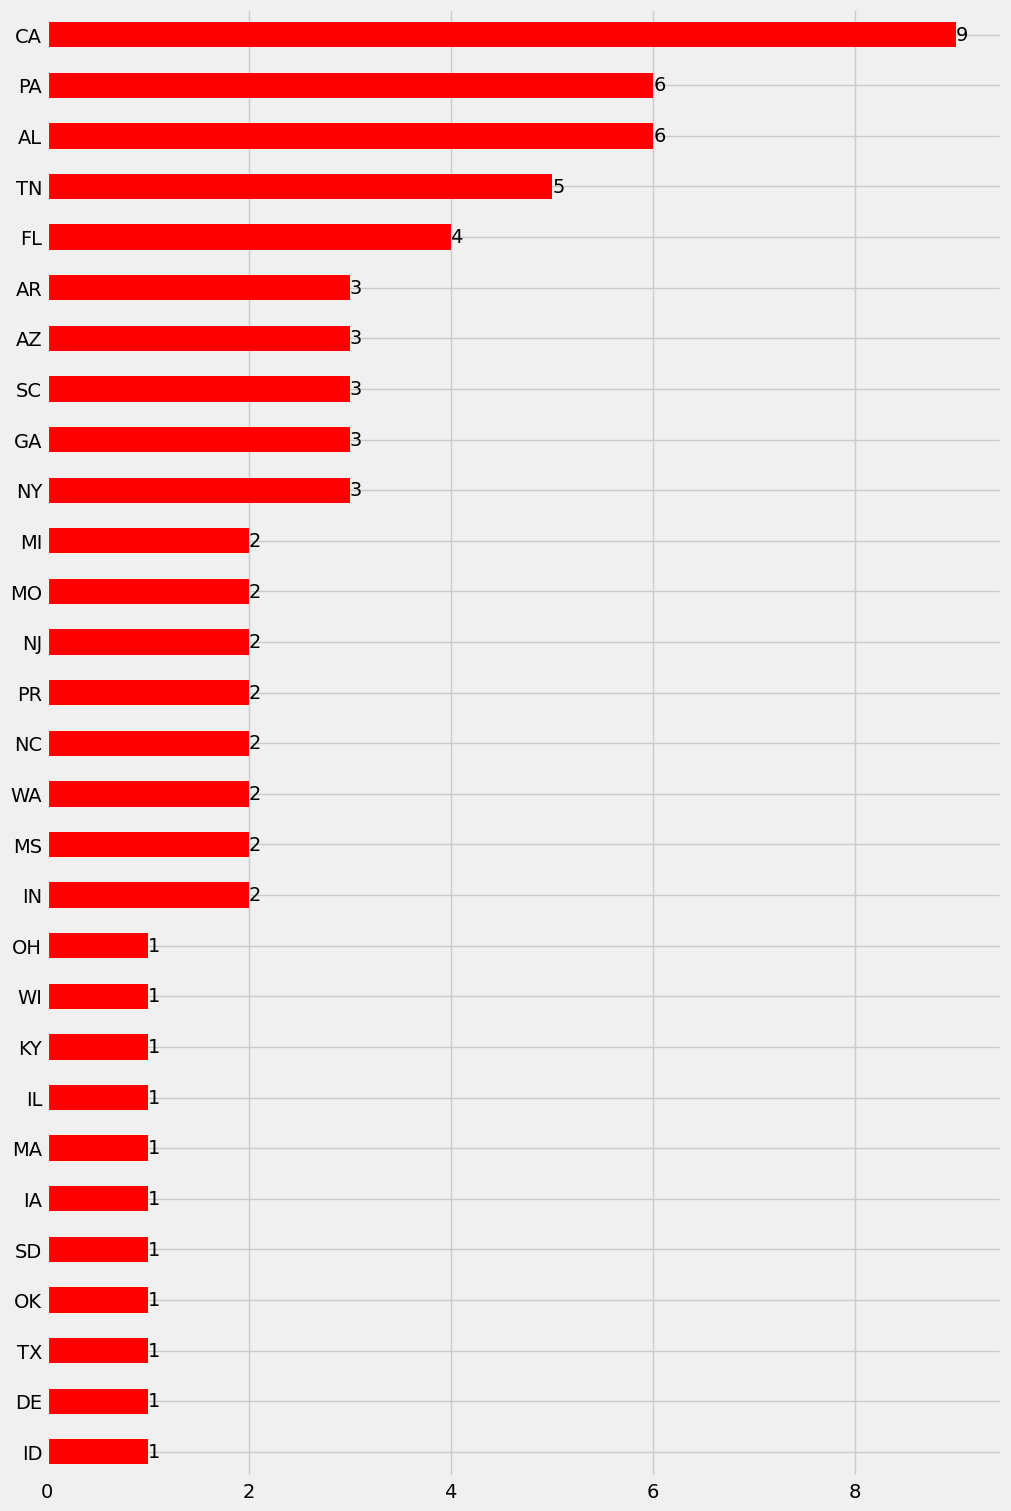

In [48]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df[cancer_df['Percentile Rank'] <= 0.10]['STATE'].value_counts().sort_values(ascending = True).plot.barh(color = 'red')
ax.bar_label(ax.containers[0])

/var/folders/sv/sf850pgs5cvc4zsv0yyq1hhr0000gn/T/ipykernel_56940/3388557634.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'STATE', data = cancer_df[cancer_df['Percentile Rank'] <= 0.20],


Text(0.5, 1.0, 'Poor Review Hospitals By State')

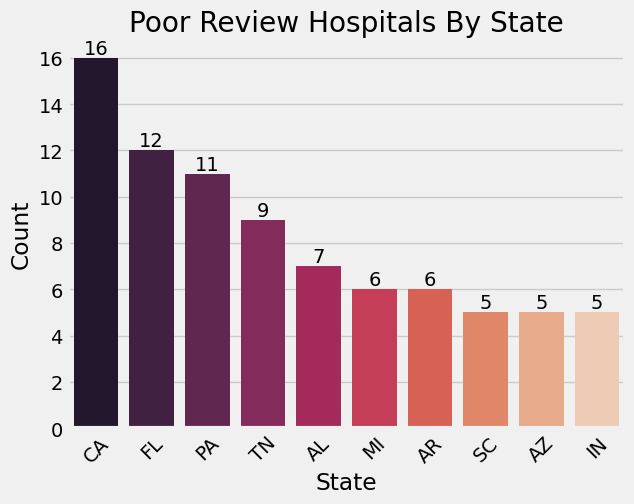

In [91]:
ax = sns.countplot(x = 'STATE', data = cancer_df[cancer_df['Percentile Rank'] <= 0.20],
              order = cancer_df[cancer_df['Percentile Rank'] <= 0.20]['STATE'].value_counts().head(10).index, palette='rocket')
for label in ax.containers:
    ax.bar_label(label)
xt = plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Poor Review Hospitals By State')

In [ ]:
# create Review Star 1-5 from Percentile Rank

In [112]:
cancer_df['STAR'] = np.where((cancer_df['Percentile Rank'] >= 0) & (cancer_df['Percentile Rank'] < 0.2),1,\
                     np.where((cancer_df['Percentile Rank'] >= 0.2) & (cancer_df['Percentile Rank'] < 0.4),2,\
                     np.where((cancer_df['Percentile Rank'] >= 0.4) & (cancer_df['Percentile Rank'] < 0.6),3,\
                     np.where((cancer_df['Percentile Rank'] >= 0.6) & (cancer_df['Percentile Rank'] < 0.8),4,\
                     np.where((cancer_df['Percentile Rank'] >= 0.8) & (cancer_df['Percentile Rank'] <= 1),5,0)))))

In [132]:
review_count_df = cancer_df.groupby(['LATITUDE','LONGITUDE','STAR'])['AHA_ID'].size().reset_index()
review_count_df.rename(columns = {'AHA_ID':'REVIEW_COUNT'},inplace = True)
review_count_df

,LATITUDE,LONGITUDE,STAR,REVIEW_COUNT
0,-33.837942,151.093220,3,1
1,8.167525,77.432271,1,1
2,18.110488,83.390071,2,1
3,18.389903,-66.098262,1,1
4,18.397929,-66.147564,1,1
...,...,...,...,...
715,47.715828,-122.178342,2,1
716,48.000981,-122.204895,2,1
717,48.214604,-114.323317,1,1
718,48.773595,-122.473688,2,1


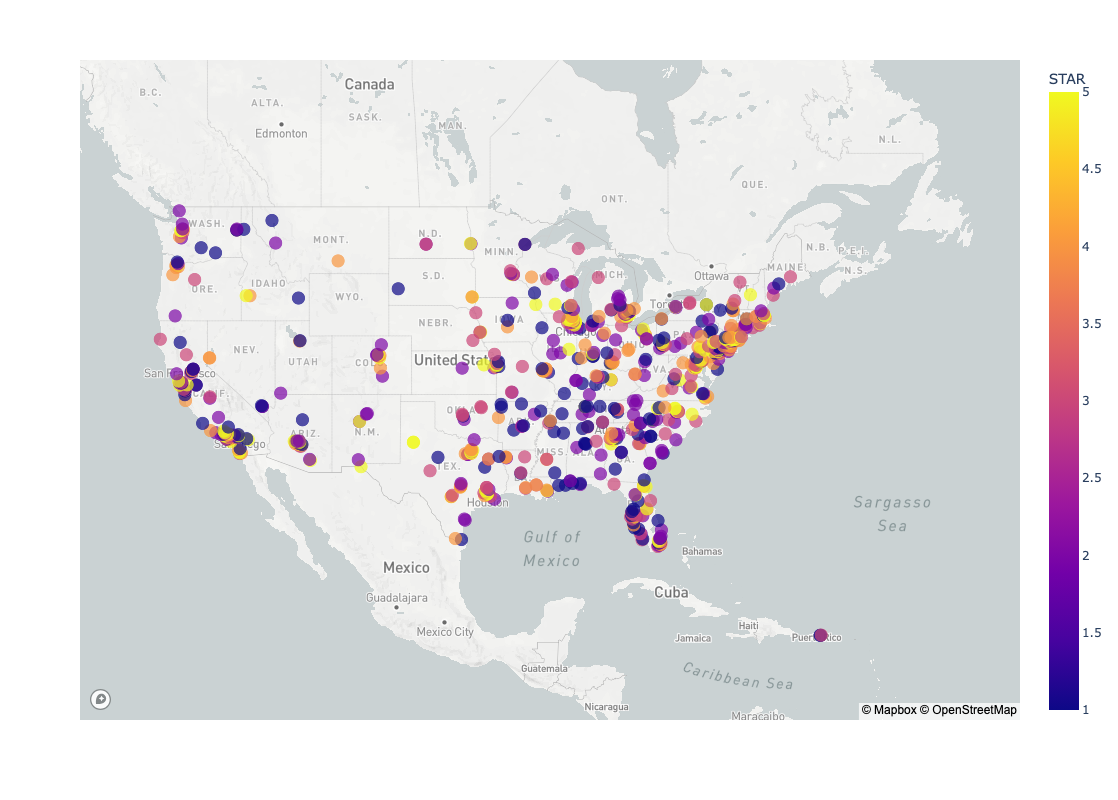

In [135]:

px.set_mapbox_access_token(mapbox_token)
#configure_plotly_browser_state()
px.scatter_mapbox(review_count_df, lat="LATITUDE", lon="LONGITUDE", color="STAR", size='REVIEW_COUNT' ,
                   size_max=10, zoom=3, width=1200, height=800)

# the existing coordinates are incorrect

In [179]:
def find_coordinates(address):
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(address, timeout=1000000)
    if location == None:
        return [0,0]
    else:
        return location.latitude,location.longitude

def Convert(lst):
    res_dct = map(lambda i: (lst[i], lst[i+1]), range(len(lst)-1)[::2])
    return dict(res_dct)

In [191]:


def find_coordinates_from_zip(zip):
    nomi = pgeocode.Nominatim('us')
    query = nomi.query_postal_code(zip)
    return query["latitude"],query["longitude"]




(nan, nan)

In [188]:
find_coordinates('')

[0, 0]

In [192]:
cancer_df['NEW_COOR'] = cancer_df['ZIP'].apply(lambda x: find_coordinates_from_zip(x))

In [193]:
cancer_df['LAT'] = cancer_df['NEW_COOR'].apply(lambda x: x[0])
cancer_df['LON'] = cancer_df['NEW_COOR'].apply(lambda x: x[1])

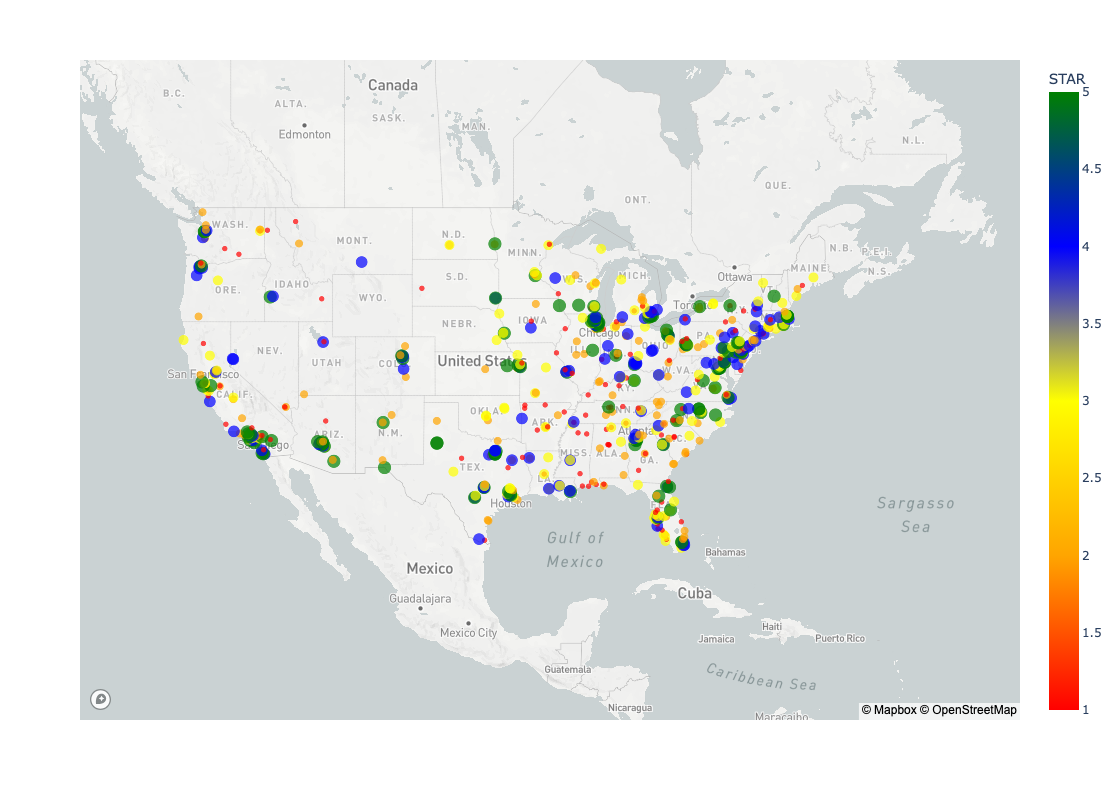

In [206]:
review_count_df = cancer_df.groupby(['LAT','LON','STAR'])['AHA_ID'].size().reset_index()
review_count_df.rename(columns = {'AHA_ID':'REVIEW_COUNT'},inplace = True)
review_count_df
px.set_mapbox_access_token(mapbox_token)
#configure_plotly_browser_state()
px.scatter_mapbox(review_count_df, lat="LAT", lon="LON", color="STAR", size='STAR' ,
                   size_max=10, zoom=3, width=1200, height=800, color_continuous_scale=['red','orange','yellow', 'blue', 'green'])

# Lookup by State
# for example California

In [209]:
def lookup_by_state(state):
    review_count_state_df = cancer_df[cancer_df['STATE'] == state].groupby(['LAT','LON','STAR'])['AHA_ID'].size().reset_index()
    review_count_state_df.rename(columns = {'AHA_ID':'REVIEW_COUNT'},inplace = True)
    return px.scatter_mapbox(review_count_state_df, lat="LAT", lon="LON", color="STAR", size='STAR' ,
                   size_max=10, zoom=3, width=1200, height=800, color_continuous_scale=['red','orange','yellow', 'blue', 'green'])

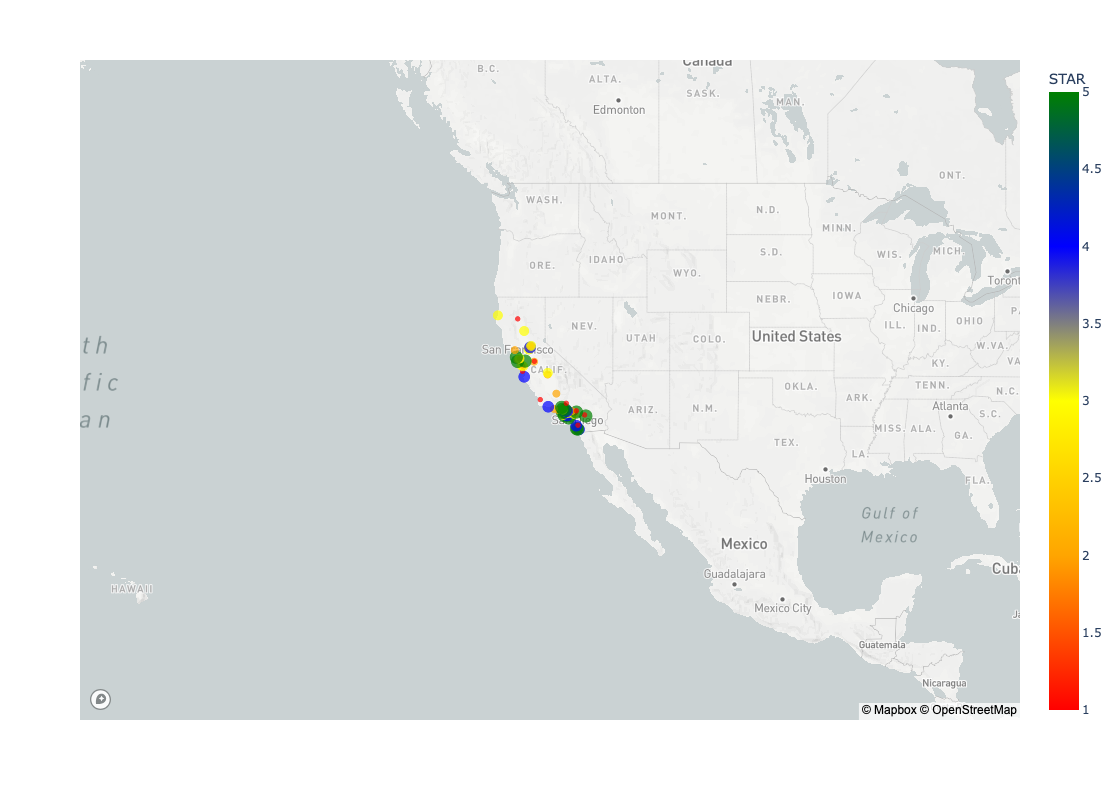

In [210]:
lookup_by_state('CA')

# Using K-Means Clustering
## Determing the number of clusters( k)

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

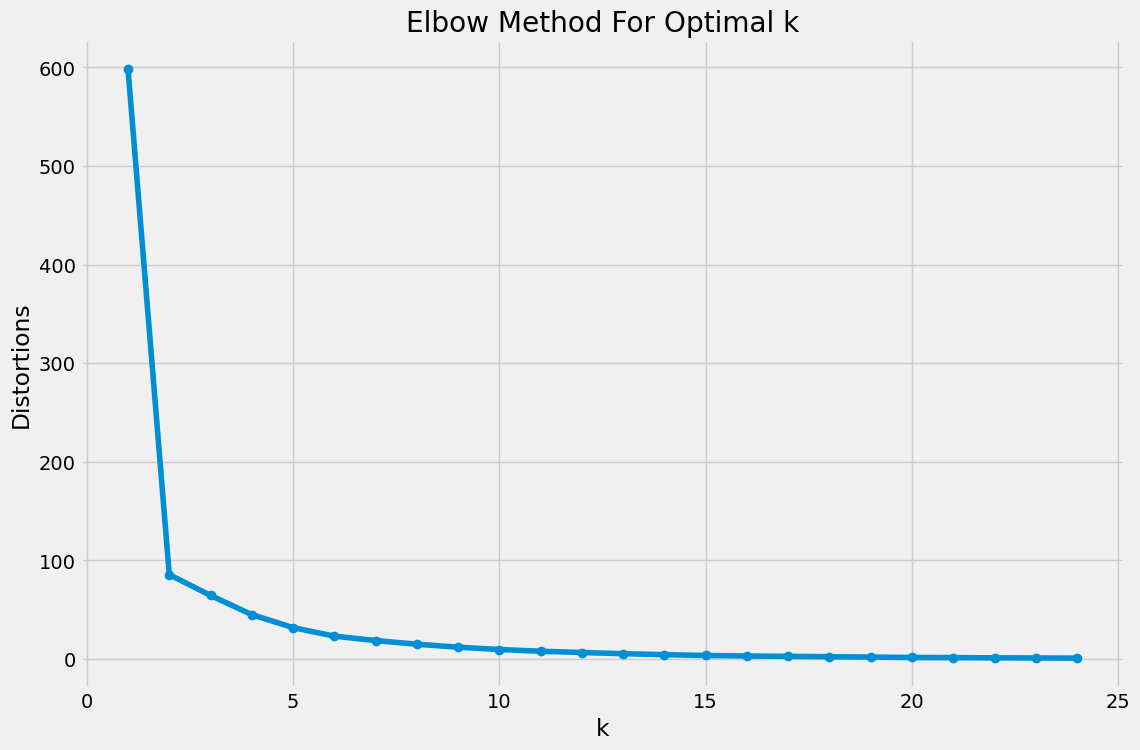

In [215]:
# Elbow method to determine the number of K in Kmeans Clustering

coords = cancer_df[cancer_df['STATE'] == 'CA'][['LON','LAT']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

In [218]:

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

# print out K mean Clusting K = 5
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 5", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

k = 5  silhouette_score  0.49795181149999845


/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# K-Means Clustering


In [219]:
coords


,LON,LAT
2,-118.2987,33.7866
4,-118.3720,34.0737
6,-121.7630,37.6830
18,-117.8776,33.7875
27,-117.2513,34.0528
...,...,...
640,-118.1491,34.6909
644,-120.9482,37.6717
652,-121.9229,37.2563
656,-121.9881,36.9721


# Location-Based Recommendation


In [222]:
CA_df = cancer_df[cancer_df['STATE'] == 'CA']

CA_df['cluster'] = kmeans.predict(CA_df[['LON','LAT']])

top_cancer_in_ca = CA_df.sort_values(by=['STAR'], ascending=False)

/var/folders/sv/sf850pgs5cvc4zsv0yyq1hhr0000gn/T/ipykernel_56940/704264967.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [231]:
def recommend_restaurants(df, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
   
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:5][['NAME', 'LAT','LON','STAR']]

In [232]:
uc_berkeley_zip = '94720'


recommend_restaurants(top_cancer_in_ca,find_coordinates_from_zip(uc_berkeley_zip)[0],  find_coordinates_from_zip(uc_berkeley_zip)[1])

4


/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,NAME,LAT,LON,STAR
94,Eisenhower Medical Center,33.7643,-116.4225,5
60,Sharp Memorial Hospital,32.7973,-117.1392,5
45,Scripps La Jolla Hospitals,32.8455,-117.2521,5
27,Loma Linda University Medical Center,34.0528,-117.2513,5
223,Scripps Memorial Hospital-Encinitas,33.0535,-117.2689,4


4


/Users/peeti_mac/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



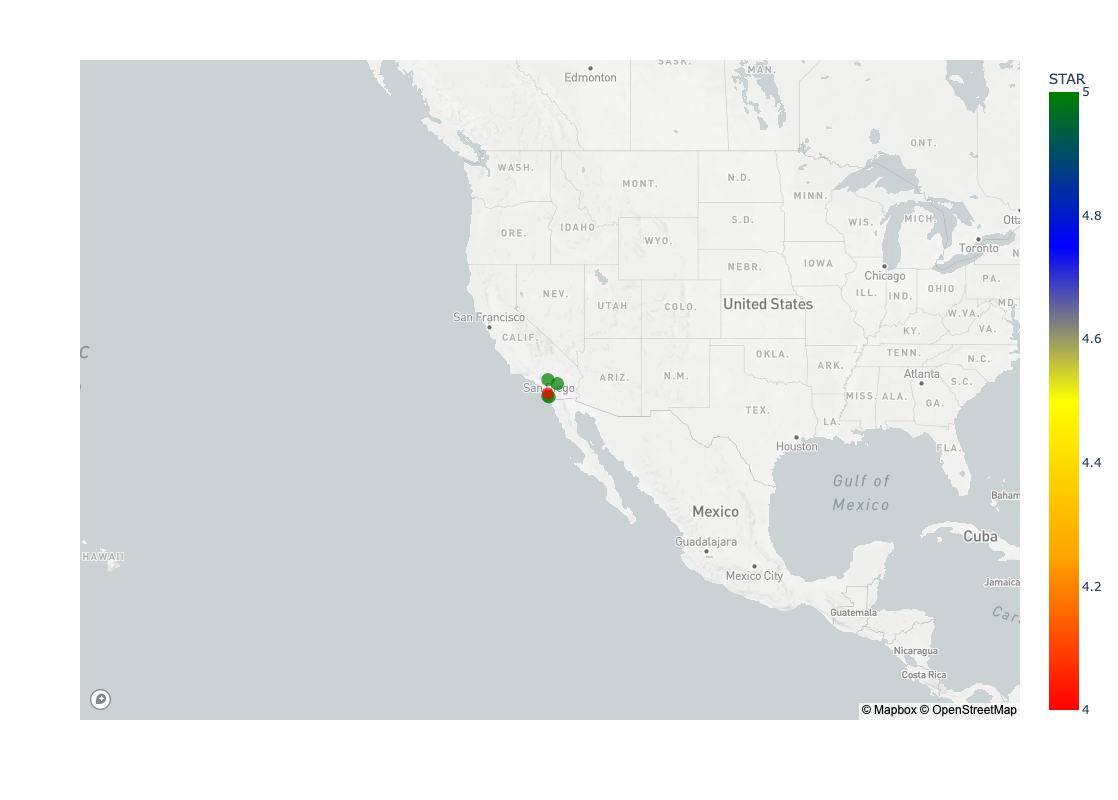

In [233]:
px.scatter_mapbox(recommend_restaurants(top_cancer_in_ca,find_coordinates_from_zip(uc_berkeley_zip)[0],  find_coordinates_from_zip(uc_berkeley_zip)[1]),
                  lat="LAT", lon="LON", color="STAR", size='STAR' ,
                   size_max=10, zoom=3, width=1200, height=800, color_continuous_scale=['red','orange','yellow', 'blue', 'green'])